## Image Feature Extraction
Use CNN to take image as input and output feature vector

https://huggingface.co/datasets/diffusers/pokemon-gpt4-captions


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from datasets import load_dataset
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import nltk
nltk.download('punkt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chester\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
class PokemonDataset(Dataset):
    def __init__(self, dataset, transform=None, freq_threshold=2):
        self.dataset = dataset
        self.transform = transform
        self.captions = [data['text'] for data in dataset]
        
        # build vocabulary
        word_freq = Counter()
        for caption in self.captions:
            word_freq.update(nltk.word_tokenize(caption.lower()))
        self.vocab = ['<PAD>', '<START>', '<END>', '<UNK>']
        self.vocab.extend([word for word, freq in word_freq.items() if freq >= freq_threshold])
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.pad_idx = self.word2idx['<PAD>']
        self.start_idx = self.word2idx['<START>']
        self.end_idx = self.word2idx['<END>']
        self.unk_idx = self.word2idx['<UNK>']
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = self.dataset[idx]['image'].convert('RGB')
        caption = self.dataset[idx]['text'].lower()
        if self.transform:
            image = self.transform(image)
        tokens = ['<START>'] + nltk.word_tokenize(caption) + ['<END>']
        caption_idx = [self.word2idx.get(token, self.unk_idx) for token in tokens]
        return image, torch.tensor(caption_idx)

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = load_dataset("diffusers/pokemon-gpt4-captions")

# 80/20split
train_test_split = dataset['train'].train_test_split(test_size=0.2, seed=42)
train_dataset_raw = train_test_split['train']
test_dataset_raw = train_test_split['test']

train_dataset = PokemonDataset(train_dataset_raw, transform=transform)
test_dataset = PokemonDataset(test_dataset_raw, transform=transform)

def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images, 0)
    captions = pad_sequence(captions, batch_first=True, padding_value=train_dataset.pad_idx)
    return images, captions

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

README.md:   0%|          | 0.00/2.21k [00:00<?, ?B/s]

c:\Users\chester\miniforge3\envs\d7047e\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\chester\.cache\huggingface\hub\datasets--diffusers--pokemon-gpt4-captions. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


(…)-00000-of-00001-a1df3b486d3a28b0.parquet:   0%|          | 0.00/51.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        for param in self.resnet.parameters():
            param.requires_grad = False
    
    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        return features

class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.fc_h = nn.Linear(2048, hidden_size)  # map resnet features to hidden size
        self.fc_c = nn.Linear(2048, hidden_size)  # map resnet features to cell state size
    
    def forward(self, features, captions):
        embeddings = self.embed(captions[:, :-1])  # exclude <END> token
        h0 = self.fc_h(features).unsqueeze(0)
        c0 = self.fc_c(features).unsqueeze(0)
        outputs, _ = self.lstm(embeddings, (h0, c0))
        outputs = self.linear(outputs)
        return outputs

In [10]:
vocab_size = len(train_dataset.vocab)
embed_size = 256
hidden_size = 512

encoder = Encoder().to(device)
decoder = Decoder(embed_size, hidden_size, vocab_size).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.pad_idx)
optimizer = optim.Adam(decoder.parameters(), lr=0.001)

num_epochs = 200
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    total_loss = 0
    for images, captions in train_loader:
        images = images.to(device)
        captions = captions.to(device)
        features = encoder(images)
        outputs = decoder(features, captions)
        targets = captions[:, 1:]  # exclude <START> token
        loss = criterion(outputs.view(-1, vocab_size), targets.contiguous().view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

torch.save(encoder.state_dict(), 'encoder.pt')
torch.save(decoder.state_dict(), 'decoder.pt')

def generate_caption(encoder, decoder, image, max_length=20):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        features = encoder(image)
        h = decoder.fc_h(features).unsqueeze(0)
        c = decoder.fc_c(features).unsqueeze(0)
        caption = []
        input_word = torch.tensor([train_dataset.start_idx]).to(device)
        for _ in range(max_length):
            embeddings = decoder.embed(input_word).unsqueeze(1)
            output, (h, c) = decoder.lstm(embeddings, (h, c))
            output = decoder.linear(output.squeeze(1))
            predicted = output.argmax(1)
            word_idx = predicted.item()
            if word_idx == train_dataset.end_idx:
                break
            caption.append(word_idx)
            input_word = predicted
        return ' '.join([train_dataset.idx2word[idx] for idx in caption])

Epoch [1/200], Loss: 4.8611
Epoch [2/200], Loss: 3.6709
Epoch [3/200], Loss: 3.2306
Epoch [4/200], Loss: 2.9456
Epoch [5/200], Loss: 2.7305
Epoch [6/200], Loss: 2.5555
Epoch [7/200], Loss: 2.4062
Epoch [8/200], Loss: 2.2676
Epoch [9/200], Loss: 2.1289
Epoch [10/200], Loss: 2.0068
Epoch [11/200], Loss: 1.8917
Epoch [12/200], Loss: 1.7693
Epoch [13/200], Loss: 1.6473
Epoch [14/200], Loss: 1.5269
Epoch [15/200], Loss: 1.4176
Epoch [16/200], Loss: 1.3151
Epoch [17/200], Loss: 1.2071
Epoch [18/200], Loss: 1.1012
Epoch [19/200], Loss: 1.0118
Epoch [20/200], Loss: 0.9250
Epoch [21/200], Loss: 0.8395
Epoch [22/200], Loss: 0.7639
Epoch [23/200], Loss: 0.6894
Epoch [24/200], Loss: 0.6277
Epoch [25/200], Loss: 0.5710
Epoch [26/200], Loss: 0.5148
Epoch [27/200], Loss: 0.4672
Epoch [28/200], Loss: 0.4240
Epoch [29/200], Loss: 0.3816
Epoch [30/200], Loss: 0.3449
Epoch [31/200], Loss: 0.3184
Epoch [32/200], Loss: 0.2917
Epoch [33/200], Loss: 0.2624
Epoch [34/200], Loss: 0.2405
Epoch [35/200], Loss: 0

Sample 1 - Generated Caption: a whimsical yellow and purple animated creature with a distinctive long , striped tail stands ready for action .
Sample 2 - Generated Caption: a <UNK> , a bug-type pokémon , with a fierce expression and a large bill ready for battle .
Sample 3 - Generated Caption: a confident <UNK> , a grass-type pokémon , strikes a dynamic pose with its leafy appendages .
Sample 4 - Generated Caption: a fierce rampardos , a rock-type fossil pokémon , stands ready for battle with its characteristic blue <UNK> head and
Sample 5 - Generated Caption: a fierce <UNK> stands ready for battle , its signature red tongue scarf flowing behind and sharp , contrasting blue
Sample 6 - Generated Caption: an illustrated <UNK> stag pokémon with a whimsical expression and tail fin raised in the air .
Sample 7 - Generated Caption: a majestic <UNK> stands poised for battle , showcasing its sharp fangs and piercing red eyes highlighting its <UNK> nature
Sample 8 - Generated Caption: a poised 

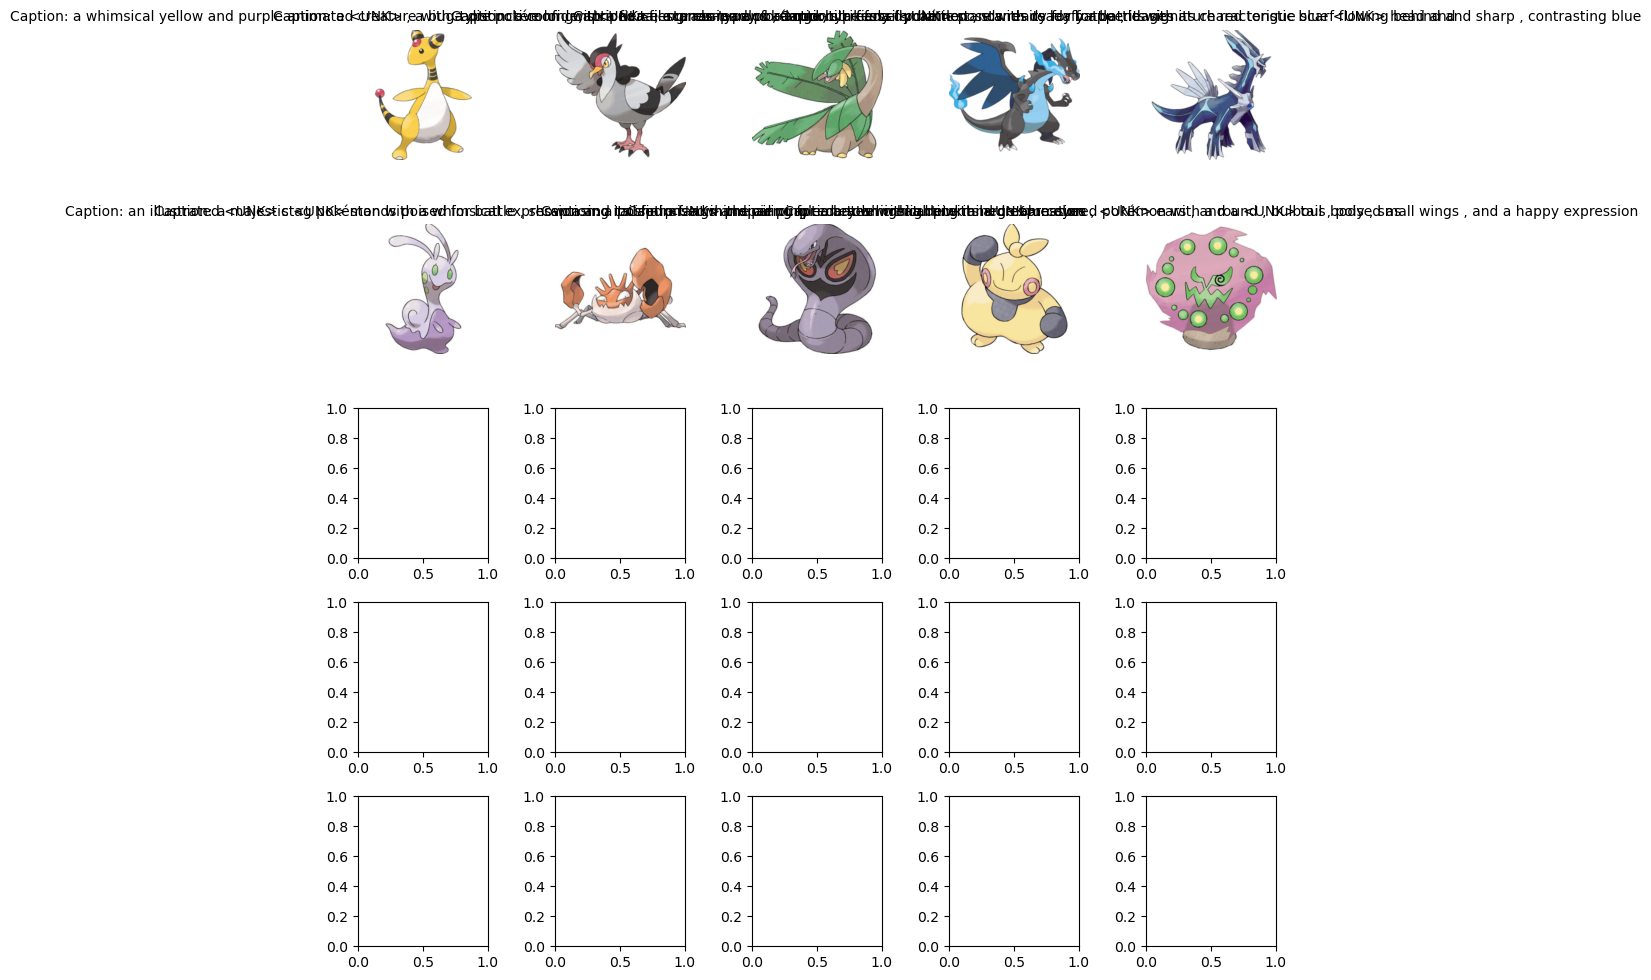

In [13]:
import matplotlib.pyplot as plt

# denormalize image for visualization
def denormalize(image_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = image_tensor.cpu() * std + mean  
    image = image.clamp(0, 1) 
    return image

def generate_caption(encoder, decoder, image, max_length=20):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        features = encoder(image)
        h = decoder.fc_h(features).unsqueeze(0)
        c = decoder.fc_c(features).unsqueeze(0)
        caption = []
        input_word = torch.tensor([train_dataset.start_idx]).to(device)
        for _ in range(max_length):
            embeddings = decoder.embed(input_word).unsqueeze(1)
            output, (h, c) = decoder.lstm(embeddings, (h, c))
            output = decoder.linear(output.squeeze(1))
            predicted = output.argmax(1)
            word_idx = predicted.item()
            if word_idx == train_dataset.end_idx:
                break
            caption.append(word_idx)
            input_word = predicted
        return ' '.join([train_dataset.idx2word[idx] for idx in caption])

num_samples = 10  
fig, axes = plt.subplots(5, 5, figsize=(10, 10)) 
axes = axes.flatten() 

for i in range(num_samples):
    test_image = test_dataset[i][0] 
    caption = generate_caption(encoder, decoder, test_image)
    print(f"Sample {i+1} - Generated Caption: {caption}")
    
    image = denormalize(test_image)
    axes[i].imshow(image.permute(1, 2, 0))  
    axes[i].set_title(f"Caption: {caption}", fontsize=10)
    axes[i].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from datasets import load_dataset
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import nltk
import matplotlib.pyplot as plt
import gensim.downloader as api
nltk.download('punkt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load pre-trained Word2Vec embeddings
print("Loading Word2Vec embeddings...")
word2vec = api.load('word2vec-google-news-300')  # 300-dimensional embeddings
print("Word2Vec embeddings loaded.")

class PokemonDataset(Dataset):
    def __init__(self, dataset, transform=None, freq_threshold=2):
        self.dataset = dataset
        self.transform = transform
        self.captions = [data['text'] for data in dataset]
        
        # build vocabulary from captions
        word_freq = Counter()
        for caption in self.captions:
            word_freq.update(nltk.word_tokenize(caption.lower()))
        self.vocab = ['<PAD>', '<START>', '<END>', '<UNK>']
        self.vocab.extend([word for word, freq in word_freq.items() if freq >= freq_threshold])
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.pad_idx = self.word2idx['<PAD>']
        self.start_idx = self.word2idx['<START>']
        self.end_idx = self.word2idx['<END>']
        self.unk_idx = self.word2idx['<UNK>']
        
        # create embedding matrix using Word2Vec
        embed_size = 300  # match Word2Vec embedding size
        self.embedding_matrix = torch.zeros(len(self.vocab), embed_size)
        for word, idx in self.word2idx.items():
            if word in word2vec:  # check if word exists in Word2Vec
                self.embedding_matrix[idx] = torch.tensor(word2vec[word])
            else:
                # random initialization for special tokens or OOV words
                self.embedding_matrix[idx] = torch.randn(embed_size)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = self.dataset[idx]['image'].convert('RGB')
        caption = self.dataset[idx]['text'].lower()
        if self.transform:
            image = self.transform(image)
        tokens = ['<START>'] + nltk.word_tokenize(caption) + ['<END>']
        caption_idx = [self.word2idx.get(token, self.unk_idx) for token in tokens]
        return image, torch.tensor(caption_idx)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = load_dataset("diffusers/pokemon-gpt4-captions")
train_test_split = dataset['train'].train_test_split(test_size=0.2, seed=42)
train_dataset_raw = train_test_split['train']
test_dataset_raw = train_test_split['test']

train_dataset = PokemonDataset(train_dataset_raw, transform=transform, freq_threshold=2)
test_dataset = PokemonDataset(test_dataset_raw, transform=transform, freq_threshold=2)

def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images, 0)
    captions = pad_sequence(captions, batch_first=True, padding_value=train_dataset.pad_idx)
    return images, captions

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        for param in self.resnet.parameters():
            param.requires_grad = False
    
    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        return features

class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, embedding_matrix, num_layers=1):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)  # use pre-trained embeddings
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.fc_h = nn.Linear(2048, hidden_size)
        self.fc_c = nn.Linear(2048, hidden_size)
    
    def forward(self, features, captions):
        embeddings = self.embed(captions[:, :-1])
        h0 = self.fc_h(features).unsqueeze(0)
        c0 = self.fc_c(features).unsqueeze(0)
        outputs, _ = self.lstm(embeddings, (h0, c0))
        outputs = self.linear(outputs)
        return outputs

vocab_size = len(train_dataset.vocab)
embed_size = 300  # match Word2Vec embedding size
hidden_size = 512

encoder = Encoder().to(device)
decoder = Decoder(embed_size, hidden_size, vocab_size, train_dataset.embedding_matrix).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.pad_idx)
optimizer = optim.Adam(decoder.parameters(), lr=0.001)

num_epochs = 200
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    total_loss = 0
    for images, captions in train_loader:
        images = images.to(device)
        captions = captions.to(device)
        features = encoder(images)
        outputs = decoder(features, captions)
        targets = captions[:, 1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.contiguous().view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

torch.save(encoder.state_dict(), 'encoder.pt')
torch.save(decoder.state_dict(), 'decoder.pt')

def generate_caption(encoder, decoder, image, max_length=20):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        features = encoder(image)
        h = decoder.fc_h(features).unsqueeze(0)
        c = decoder.fc_c(features).unsqueeze(0)
        caption = []
        input_word = torch.tensor([train_dataset.start_idx]).to(device)
        for _ in range(max_length):
            embeddings = decoder.embed(input_word).unsqueeze(1)
            output, (h, c) = decoder.lstm(embeddings, (h, c))
            output = decoder.linear(output.squeeze(1))
            predicted = output.argmax(1)
            word_idx = predicted.item()
            if word_idx == train_dataset.end_idx:
                break
            caption.append(word_idx)
            input_word = predicted
        return ' '.join([train_dataset.idx2word[idx] for idx in caption])



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chester\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading Word2Vec embeddings...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2Vec embeddings loaded.
Epoch [1/200], Loss: 4.8452
Epoch [2/200], Loss: 3.8987
Epoch [3/200], Loss: 3.6115
Epoch [4/200], Loss: 3.4148
Epoch [5/200], Loss: 3.2342
Epoch [6/200], Loss: 3.0891
Epoch [7/200], Loss: 2.9546
Epoch [8/200], Loss: 2.8318
Epoch [9/200], Loss: 2.7247
Epoch [10/200], Loss: 2.6299
Epoch [11/200], Loss: 2.5424
Epoch [12/200], Loss: 2.4583
Epoch [13/200], Loss: 2.3687
Epoch [14/200], Loss: 2.2830
Epoch [15/200], Loss: 2.2058
Epoch [16/200], Loss: 2.1297
Epoch [17/200], Loss: 2.0451
Epoch [18/200], Loss: 1.9644
Epoch [19/200], Loss: 1.8889
Epoch [20/200], Loss: 1.8214
Epoch [21/200], Loss: 1.7430
Epoch [22/200], Loss: 1.6642
Epoch [23/200], Loss: 1.5981
Epoch [24/200], Loss: 1.5147
Epoch [25/200], Loss: 1.4376
Epoch [26/200], Loss: 1.3620
Epoch [27/200], Loss: 1.2784
Epoch [28/200], Loss: 1.2237
Epoch [29/200], Loss: 1.1706
Epoch [30/200], Loss: 

Sample 1 - Generated Caption: a whimsical yellow and brown <UNK> creature with a sharp horn and a wide-open mouth , seemingly in mid-action or
Sample 2 - Generated Caption: a <UNK> , a fire-type pokémon , that appears with signature <UNK> and a <UNK> expression , looking ready to
Sample 3 - Generated Caption: a fierce <UNK> from the , showcasing its signature black and <UNK> fur with it .
Sample 4 - Generated Caption: a fierce <UNK> pokémon spreads its wings with a determined expression .
Sample 5 - Generated Caption: a sleek , <UNK> pokémon with a sleek , <UNK> mane and a <UNK> , ready for battle .
Sample 6 - Generated Caption: a whimsical illustration of <UNK> , a <UNK> pokémon , with a green body and a <UNK> red gem <UNK>
Sample 7 - Generated Caption: a poised <UNK> stands ready for battle , its sharp claws and <UNK> pose .
Sample 8 - Generated Caption: a poised <UNK> stands ready for battle , showcasing its sturdy armor-like <UNK> and prominent tusks .
Sample 9 - Generated Caption:

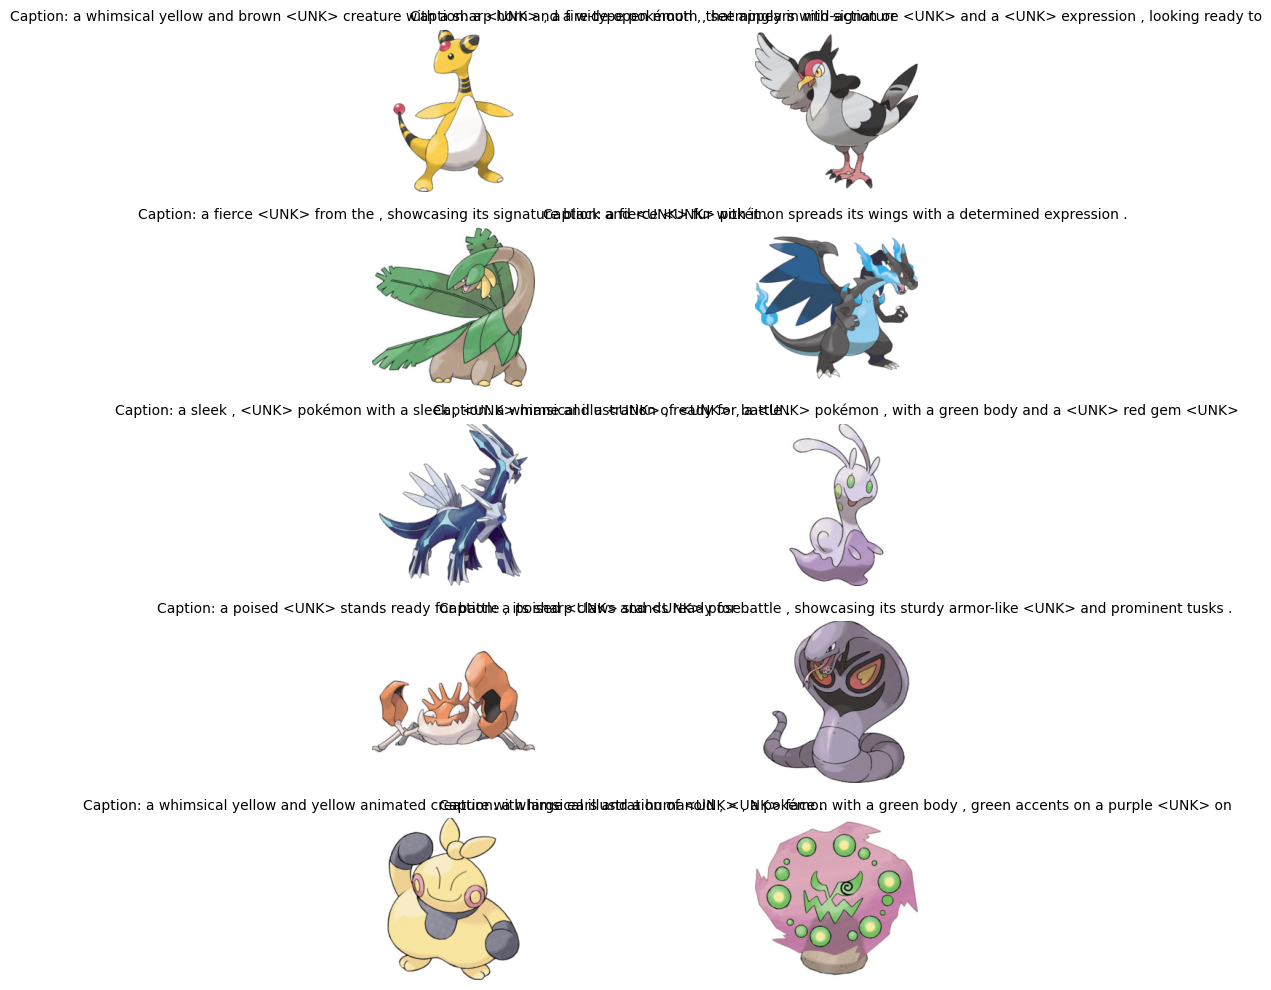

In [ ]:
def denormalize(image_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = image_tensor.cpu() * std + mean
    image = image.clamp(0, 1)
    return image

num_samples = 10
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
axes = axes.flatten()

for i in range(num_samples):
    test_image = test_dataset[i][0]
    caption = generate_caption(encoder, decoder, test_image)
    print(f"Sample {i+1} - Generated Caption: {caption}")
    image = denormalize(test_image)
    axes[i].imshow(image.permute(1, 2, 0))
    axes[i].set_title(f"Caption: {caption}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Import Dataset

In [46]:
ds = load_dataset("diffusers/pokemon-gpt4-captions")
print(ds)

ds = ds["train"].train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})


## Exploratory Data Analysis

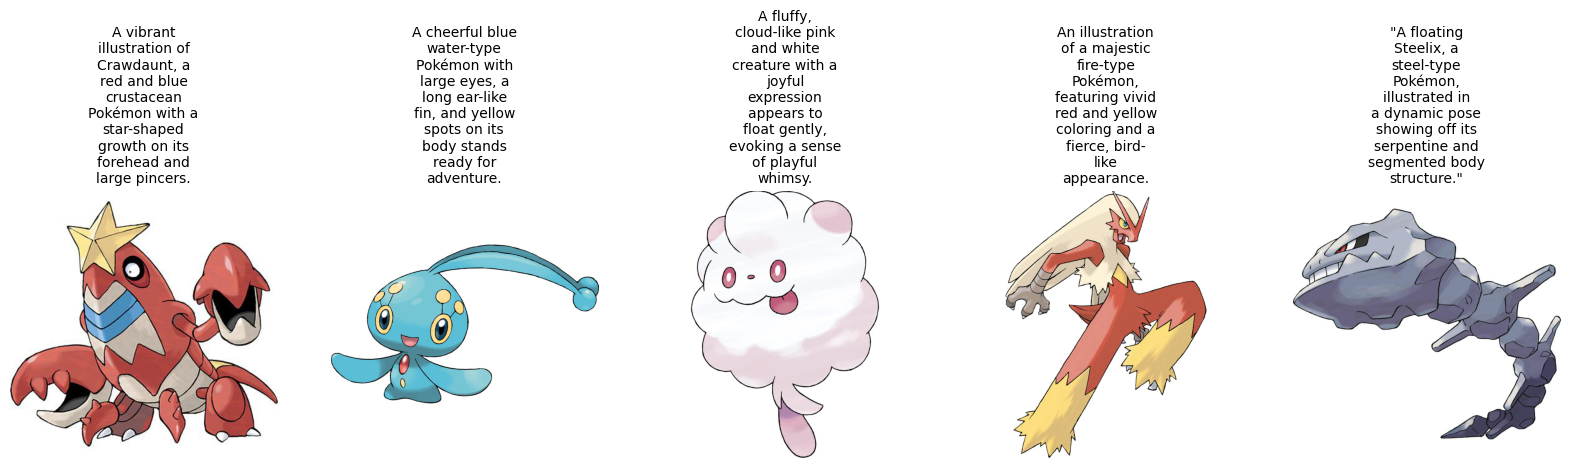

In [42]:
def show_images_from_dataset(dataset, num_samples=5):
    plt.figure(figsize=(20, 15))
    for i in range(num_samples):
        image = np.array(dataset[i]["image"])
        caption = dataset[i]["text"]
        ax = plt.subplot(1, num_samples, i + 1)
        ax.set_title("\n".join(wrap(caption, 15)), fontsize=10)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

show_images_from_dataset(train_ds, num_samples=5)